## **Desafio Machine Learning**

Este repositório contém um dataset com 7121 formulas de medicamentos manipulados.

O objetivo do teste é prever o valor da coluna "correto" com menor erro possível a partir das outras informações do dataset.

dos 7121 pontos de dados, podem usar no máximo os primeiros 5121 dados do dataset para prever os últimos 2000

podem usar o link https://raw.githubusercontent.com/manipulaeHealth/desafio-machine-learning/main/dados_preco.csv para baixar direto no pandas



## **Orientações**

Necessário usar Python, ficando livre o uso de qualquer biblioteca;
Necessário disponibilizar o código de forma que consigamos reproduzir o que foi feito, pode ser em um repositório ou notebook no colab research;

**Diferencial Opcional**
Se possível fazer um relatório usando Power BI para análises no Dataset e compartilhar o pbx depois.

**Colunas do Dataset:**
descricao
descrição da formula, seguindo o padrão:

qtd unidade_volume | insumos separados por ';'

a unidade de volume vai ser sempre CAP no dataset

os insumos vão ter o padrão:
    nome do insumo qtdunidade;  

    ex: zinco quelado 20mg;

**criado**

*   data de criação da formula


**qtdInsumos**


*   quantidade de insumos da formula




**calculado**
*   preço pré-calculado da formula

**correto**
*   preço correto da formula, o objetivo é prever ele

# Bibliotecas necessárias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import (RandomForestRegressor,
                               GradientBoostingRegressor,
                               ExtraTreesRegressor,
                               StackingRegressor)
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
pd.set_option('display.max_colwidth', None)

### Carregando os dados

In [2]:
url = "https://raw.githubusercontent.com/manipulaeHealth/desafio-machine-learning/main/dados_preco.csv"
data = pd.read_csv(url)
data.head()

,descricao,criado,qtdInsumos,calculado,correto
0,30 CAP | BUPROPIONA CLORIDRATO 150MG,2020-08-05 23:19:09,1,47.5297,39.9
1,60 CAP | FINASTERIDA 1:10 1MG,2020-08-05 22:51:09,1,46.9620,43.6
2,60 CAP | NAC 250MG; SILIMARINA 150MG; SAME 50MG,2020-08-05 22:51:09,3,105.1390,111.4
3,60 CAP | ANASTROZOL 1:10 0.300MG,2020-08-05 22:51:09,1,49.0314,43.6
4,120 CAP | DUTASTERIDA 0.250MG; TADALAFIL 10MG,2020-08-05 22:49:09,2,161.8272,146.0


### Verificando as informações e tipos de dados

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7121 entries, 0 to 7120
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   descricao   7121 non-null   object 
 1   criado      7121 non-null   object 
 2   qtdInsumos  7121 non-null   int64  
 3   calculado   7121 non-null   float64
 4   correto     7121 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 278.3+ KB
None


In [4]:
# Estatísticas descritivas
print(data.describe())

        qtdInsumos     calculado       correto
count  7121.000000   7121.000000   7121.000000
mean      3.281842    137.089552    135.891798
std       3.194301    191.266516    189.806974
min       1.000000     30.000100     33.000000
25%       1.000000     49.786100     49.500000
50%       2.000000     87.350300     83.100000
75%       4.000000    165.167000    161.200000
max      26.000000  10364.992500  10356.000000


In [5]:
# Verificar a presença de valores nulos
print(data.isnull().sum())

descricao     0
criado        0
qtdInsumos    0
calculado     0
correto       0
dtype: int64


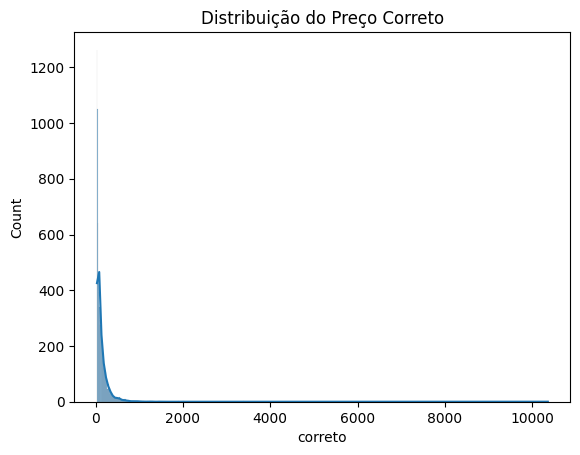

In [6]:
# Analisar a distribuição da variável alvo
sns.histplot(data['correto'], kde=True)
plt.title('Distribuição do Preço Correto')
plt.show()

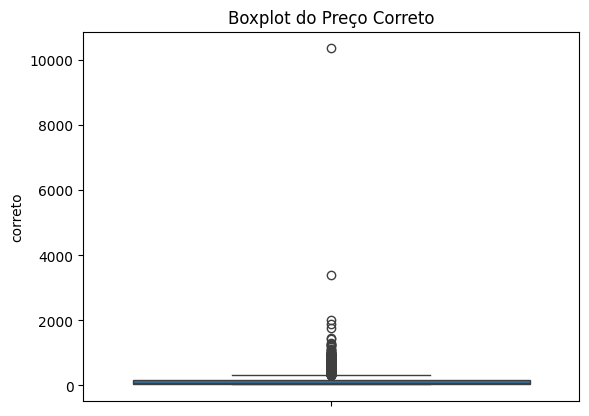

In [7]:
# Verificar a presença de possíveis outliers
sns.boxplot(data['correto'])
plt.title('Boxplot do Preço Correto')
plt.show()

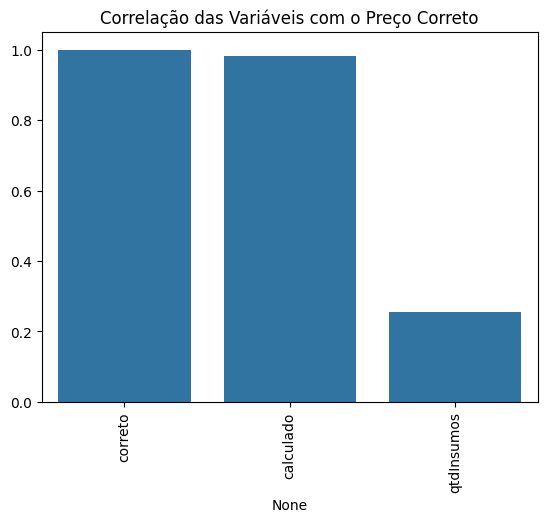

In [8]:
# Filtrar apenas as colunas numéricas para análise de correlação
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Checar a correlação com a variável alvo
correlation = numeric_data.corr()['correto'].sort_values(ascending=False)
sns.barplot(x=correlation.index, y=correlation.values)
plt.title('Correlação das Variáveis com o Preço Correto')
plt.xticks(rotation=90)
plt.show()

### Modelagem

In [9]:
# Remover outliers extremos
q_low = data["correto"].quantile(0.01)
q_hi = data["correto"].quantile(0.99)
data_filtered = data[(data["correto"] < q_hi) & (data["correto"] > q_low)]

In [10]:
# Preparar dados para treinamento
X = data_filtered.drop(['descricao', 'criado', 'correto'], axis=1)
y = data_filtered['correto']

# Split dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:5121], y.iloc[:5121], test_size=2000, random_state=42)

# Definindo os parâmetros para Grid Search
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

gb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

et_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

ridge_param_grid = {
    'alpha': [0.1, 1.0, 10.0]
}

lasso_param_grid = {
    'alpha': [0.1, 1.0, 10.0]
}

# Treinamento e Grid Search para todos os modelos
rf_grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rf_param_grid, scoring='r2', cv=3, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

gb_grid_search = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=gb_param_grid, scoring='r2', cv=3, n_jobs=-1)
gb_grid_search.fit(X_train, y_train)

et_grid_search = GridSearchCV(estimator=ExtraTreesRegressor(), param_grid=et_param_grid, scoring='r2', cv=3, n_jobs=-1)
et_grid_search.fit(X_train, y_train)

xgb_grid_search = GridSearchCV(estimator=XGBRegressor(), param_grid=xgb_param_grid, scoring='r2', cv=3, n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

ridge_grid_search = GridSearchCV(estimator=Ridge(), param_grid=ridge_param_grid, scoring='r2', cv=3, n_jobs=-1)
ridge_grid_search.fit(X_train, y_train)

lasso_grid_search = GridSearchCV(estimator=Lasso(), param_grid=lasso_param_grid, scoring='r2', cv=3, n_jobs=-1)
lasso_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1.0, 10.0]}, scoring='r2')

### Avaliação dos modelos

In [11]:
# Avaliação dos modelos
def evaluate_model(model, X, y):
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    rmse = mse ** 0.5  # Cálculo do RMSE
    return mse, mae, r2, rmse

# Avaliar os modelos e armazenar resultados
results = {}
models = {
    'Random Forest': rf_grid_search.best_estimator_,
    'Gradient Boosting': gb_grid_search.best_estimator_,
    'Extra Trees': et_grid_search.best_estimator_,
    'XGBoost': xgb_grid_search.best_estimator_,
    'Ridge': ridge_grid_search.best_estimator_,
    'Lasso': lasso_grid_search.best_estimator_,
}

for model_name, model in models.items():
    mse, mae, r2, rmse = evaluate_model(model, X_test, y_test)
    results[model_name] = {
        'MSE': mse,
        'MAE': mae,
        'R²': r2,
        'RMSE': rmse
    }

# Imprimir os resultados
for model_name, metrics in results.items():
    print(f"{model_name}: MSE = {metrics['MSE']:.4f}, MAE = {metrics['MAE']:.4f}, R² = {metrics['R²']:.4f}, RMSE = {metrics['RMSE']:.4f}")

# Encontrar o melhor modelo com base em uma combinação ponderada das métricas
def combined_score(metrics):
    # Define a importância dos diferentes elementos das métricas
    weight_mse = 0.25
    weight_mae = 0.25
    weight_r2 = 0.5  # R² é melhor quando maior
    return (weight_mse * metrics['MSE'] + 
            weight_mae * metrics['MAE'] - 
            weight_r2 * metrics['R²'] + 
            metrics['RMSE'])  # Para R², subtraímos, pois queremos maximizar

# Avaliar o score dos modelos
model_scores = {name: combined_score(metrics) for name, metrics in results.items()}

# Encontrar o melhor modelo
best_model_name = min(model_scores, key=model_scores.get)  # Escolher o menor score
print(f"O melhor modelo é: {best_model_name}")

# Calcular as métricas para o melhor modelo
best_model_metrics = results[best_model_name]
print(f"{best_model_name} métricas: MSE = {best_model_metrics['MSE']:.4f}, MAE = {best_model_metrics['MAE']:.4f}, "
      f"R² = {best_model_metrics['R²']:.4f}, RMSE = {best_model_metrics['RMSE']:.4f}")

Random Forest: MSE = 481.6208, MAE = 10.3740, R² = 0.9611, RMSE = 21.9459
Gradient Boosting: MSE = 416.5397, MAE = 9.6485, R² = 0.9664, RMSE = 20.4093
Extra Trees: MSE = 397.7010, MAE = 9.5320, R² = 0.9679, RMSE = 19.9424
XGBoost: MSE = 405.4542, MAE = 9.7164, R² = 0.9673, RMSE = 20.1359
Ridge: MSE = 431.7419, MAE = 11.1520, R² = 0.9652, RMSE = 20.7784
Lasso: MSE = 431.7237, MAE = 11.1491, R² = 0.9652, RMSE = 20.7780
O melhor modelo é: Extra Trees
Extra Trees métricas: MSE = 397.7010, MAE = 9.5320, R² = 0.9679, RMSE = 19.9424


### Salva previsões do melhor modelo em um CSV

**Column "Predictions":**
- Esta coluna contém os valores que foram previstos pelo modelo treinado. Especificamente, representa a previsão do preço correto da fórmula medicamentosa, calculada pelo melhor modelo (que foi escolhido baseado nas métricas de desempenho).
- Exemplo: Se o modelo previu que o preço correto para uma fórmula é 45.0, esse valor será armazenado nesta coluna.

**Column "Actual":**
- Contém os valores reais que foram observados, ou seja, o preço correto da fórmula conforme registrado nos dados originais. Este valor serve como a verdade de referência para comparar com as previsões do modelo.
- Exemplo: Se o preço corretamente registrado para a mesma fórmula era 43.6, esse valor estará na coluna "Actual".

In [ ]:
predictions_df = pd.DataFrame({
    'Predictions': models[best_model_name].predict(X_test),
    'Actual': y_test.values  # Adiciona os preços corretos
})

predictions_df.to_csv('previsoes.csv', index=False)
print("Previsões salvas no arquivo 'previsoes.csv'.")

Previsões salvas no arquivo 'previsoes.csv'.
